# Calculate heatwave occurrances 

Heat waves are defined here using the index proposed in Jacob et al. [2013] modified to use daily minimum temperature data instead of maximum. Any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature seasons for the recent past (1986-2005) is considered to be a heat wave. 


## Heatwave frequency, length, and load

It's generally recognised that there are several aspects of heatwave that needs to be tracked - how often they happen (frequency), how long they are (length), and how intense they are (load). Indicators for these will tend to overlap a lot, so you don't expect to see much difference in trends between them.

Frequency

Simple count of the periods >3 days. Can be iffy because heatwaves can get so long that they turn into one long heatwave (so count actually goes down)

Length

Strong overlap with frequency - just the total number of days of heatwave. I think this is straight up a better way of measuring the 'amount' of heatwaves.

Mean length

> NEW! Just thought of it!

This is probably more the 'length' metric people care about for health - how long on average does a single heatwave last. Can simply divide the total length by the frequency.


Load

> NEW!

Following the idea of 'cooling degree days', we sum the differences between the heatwave threshold and the mean temperature. This produces a value in degree-days which should capture the intensity as well as length of days.

A similar measure could also capture just the change in mean intensity (similar to mean length, maybe divide by total number of days).




The change in heatwave index is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).


# Notes

Think i can ditch 'events' completely, its superceeded by total days. Instead add the mean length -> are heatwaves getting longer? and the load -> are they getting more intense?


In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl

from scipy import stats
from numba import jit
from tqdm import tnrange, tqdm_notebook, tqdm
from joblib import Parallel, delayed

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

import heatwave_indices

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

### Setup Paths

> NOTE: considered just adding the newest year each time instead of re-calculating the whole thing. HOWEVER in reality, the input data is still changing year to year, so far have needed to re-calculate anyway (e.g. change in resolution, change from ERAI to ERA5, in the future probably use ERA5-Land, etc). Although it seems like a cool idea to have a reproducible method where each year you just add one thing, in practice its better to have one 'frozen' output corresponding to each publication, so that it's easy to go back later to find data corresponding to specific results. Additionally, generating one file per year means you have a folder full of files that are harder to share, and the outputs are in the end pretty small (<50MB in Float32)}.

In [3]:
MAX_YEAR = 2019

REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/heatwaves/').absolute()

TEMPERATURES_FOLDER = WEATHER_SRC / 'era5' / 'daily_temperature_summary'
CLIMATOLOGY_QUANTILES = WEATHER_SRC / 'era5' / 'daily_tas_quantiles_1986-2005.nc'


INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_era5_0.5deg'
INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2020'

In [4]:
assert INTERMEDIATE_RESULTS_FOLDER.is_dir()
assert RESULTS_FOLDER.is_dir()

# Load ERA5 reference temperature quantiles

In [5]:
t_min_threshold = xr.open_dataset(CLIMATOLOGY_QUANTILES)
t_min_threshold = t_min_threshold.t_min.sel(quantile=0.99, drop=True)

In [6]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(t_min_threshold.latitude))

In [7]:
# Load ERA5 minimum temperatures
# Actually just load one file at a time to do the calculations - simpler parallel work
# t_min = xr.open_mfdataset(sorted(list(MIN_TEMPERATURES_FOLDER.glob('*.nc')))).t_min

# Define calculation functions for counting heatwave occurances

Method is to convert the $T_{min}$ lat/lon/time cube to a boolean of cells where $T_{min} > T_{99}$, where $T_{99}$ is the 99th percentile of daily $T_{min}$.

## Heatwaves whole year

In this new definition we consider all the months, because key locations (notably northern india) actually have their hottest period outside the standard summer (May-June) - although it is generally also a dry season, it's a different work to decide which is more dangerous.

> Note that because we use the 99th percentile drawn from the whole year, we will not accidentially include unusally hot winter days because we look at the top temperatures across the whole year, which will never be 'hot cold days'


In [8]:
def apply_func_for_file(func, year_file, reference_data, var_name='t_min', days_threshold=3):
    # Could just get that as an arg...
    year = int(year_file.name.split('_')[0])
    dataset_year = xr.open_dataset(year_file)[var_name]
    
    result = func(dataset_year, reference_data, days_threshold)
    # Add a year dimension matching the input file
    result = result.expand_dims(dim={'year': [year]})
    return year, result

def apply_func_and_save(func, year_file, output_file, reference_data,  var_name='t_min', days_threshold=3, overwrite=False):
    if output_file.exists() is False and overwrite is False:
        year, result = apply_func_for_file(func, year_file, reference_data, var_name='t_min', days_threshold=3)
        result.to_netcdf(output_file)
        return f'Created {output_file}'
    else:
        return f'Skipped {output_file}, already exists'

In [9]:
temperature_files= [TEMPERATURES_FOLDER / f'{year}_temperature_summary.nc' for year in range(1980, MAX_YEAR+1)]

### Heatwave Counts

In [13]:
out = Parallel(n_jobs=-1, verbose=2)(
    delayed(apply_func_for_file)(heatwave_indices.heatwaves_counts, file, t_min_threshold) for file in  temperature_files
)
# Use the year returned from the parallel func to sort the outputs before concat
out = [item[1] for item in sorted(out, key=lambda i: i[0])]
heatwaves_counts = xr.concat(out, dim='year')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   6 out of  40 | elapsed:    8.5s remaining:   48.3s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:   11.5s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.9s finished


In [14]:
heatwaves_counts.to_dataset(name='heatwaves_counts').to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwaves_counts_1980-{MAX_YEAR}.nc', 
                                                               encoding={'heatwaves_counts':{'dtype':'int16'}})

In [20]:
# Alternative approach: saving each file one at a time.
# out_folder = INTERMEDIATE_RESULTS_FOLDER / 'heatwave_counts'
# out_folder.mkdir(exist_ok=True)
# proc_files = [ (TEMPERATURES_FOLDER / f'{year}_temperature_summary.nc', out_folder / f'{year}_heatwave_count.nc') for year in range(1980, 2018+1)]
#out = Parallel(n_jobs=-1, verbose=2)(
#     delayed(apply_func_and_save)(heatwave_indices.heatwaves_counts, in_file, out_file, t_min_threshold) for in_file, out_file in  proc_files
# )

### Heatwave number of days

In [17]:
out = Parallel(n_jobs=-1, verbose=2)(
    delayed(apply_func_for_file)(heatwave_indices.heatwaves_days, file, t_min_threshold) for file in  temperature_files
)
# Use the year returned from the parallel func to sort the outputs before concat
out = [item[1] for item in sorted(out, key=lambda i: i[0])]
heatwaves_days = xr.concat(out, dim='year')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   6 out of  40 | elapsed:    5.0s remaining:   28.2s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    6.2s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.1s finished


In [19]:
heatwaves_days.to_dataset(name='heatwaves_days').to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwaves_days_1980-{MAX_YEAR}.nc',
                                                           encoding={'heatwaves_days':{'dtype':'int16'}})

### Heatwave degree-days

In [23]:
out = Parallel(n_jobs=-1, verbose=2)(
    delayed(apply_func_for_file)(heatwave_indices.heatwaves_degree_days, file, t_min_threshold) for file in  temperature_files
)
# Use the year returned from the parallel func to sort the outputs before concat
out = [item[1] for item in sorted(out, key=lambda i: i[0])]
heatwaves_deg_days = xr.concat(out, dim='year').sortby('year')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   6 out of  40 | elapsed:    5.5s remaining:   31.4s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    7.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.5s finished


In [24]:
heatwaves_deg_days.to_dataset(name='heatwaves_deg_days').to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwaves_deg_days_1980-{MAX_YEAR}.nc')

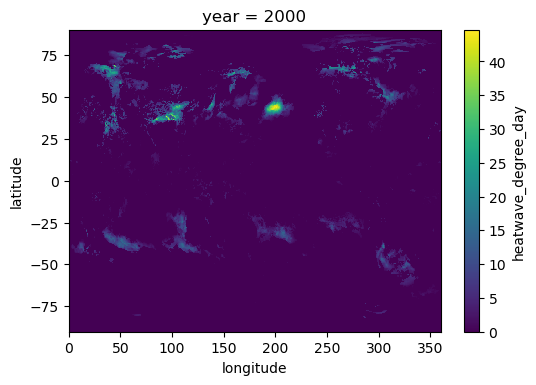

In [26]:
heatwaves_deg_days.sel(year=2000).plot()

Degree days global trend

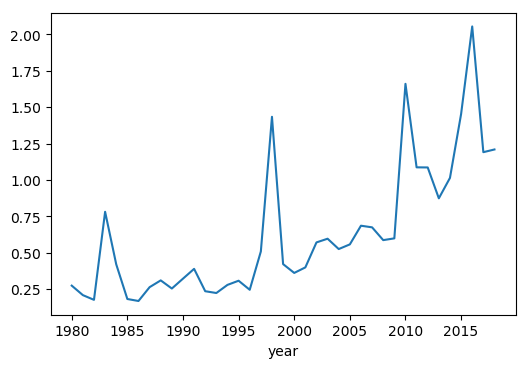

In [84]:
(heatwaves_deg_days * cos_lat).mean(dim=['latitude', 'longitude']).plot()

### Heatwave length

This is more accurate to call 'length' than what has been referred to as HW length so far - its tracking on average per heatwave and year how long each heatwave is. This is much better combined with replacement of heatwave N events with heatwave N days. Since the N events could be misleading if you have one long heatwave, better to calculate the total number of days and the total number of days per heatwave, to answer the questions "Are there more heatwaves overall?" and "Are heatwaves getting longer?"

In [27]:
heatwave_mean_length = heatwaves_days / heatwaves_counts

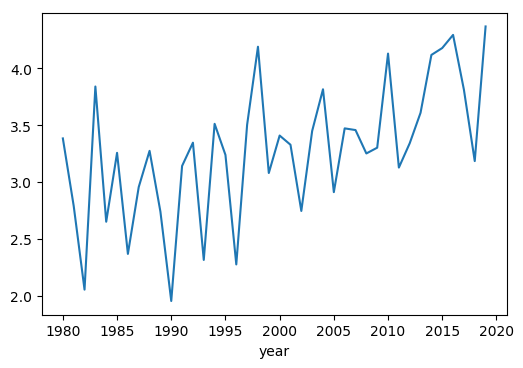

In [28]:
(heatwave_mean_length*cos_lat).mean(dim=['latitude', 'longitude']).plot()

In [33]:
heatwave_mean_length.to_dataset(name='heatwave_mean_length').to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_mean_length_1980-{MAX_YEAR}.nc',
                                                                      encoding={'heatwave_mean_length':{'dtype':'float32'}})

### Heatwave mean degrees

A bit more 'far out' than the mean length: if we divide the degree-days by the total number of days, we get a value in degrees which is something like the mean degrees above the historical threshold. This should tell us if the mean intensity (given by the temperature above historical conditions) is changing



In [34]:
heatwave_degrees = heatwaves_deg_days / heatwaves_days

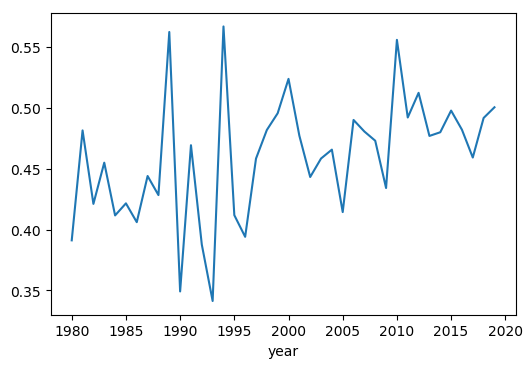

In [36]:
(heatwave_degrees*cos_lat).mean(dim=['latitude', 'longitude']).plot()

In [35]:
heatwave_degrees.to_dataset(name='heatwave_degrees').to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_degrees_1980-{MAX_YEAR}.nc',
                                                                      encoding={'heatwave_degrees':{'dtype':'float32'}})

# Calculate days only when using summer only

In [10]:
t_min_summer_threshold = (xr.open_dataset(WEATHER_SRC / 'era5' / 'daily_summer_tas_quantiles_1986-2005.nc')
                          .t_min
                          .sel(quantile=0.99, drop=True)
                          .load())

In [12]:
def apply_func_for_summer(func, year_file, reference_data, var_name='t_min', days_threshold=3):
    # Could just get that as an arg...
    year = int(year_file.name.split('_')[0])
    dataset_year = xr.open_dataset(year_file)[var_name]
    
    season_selector = np.logical_or(dataset_year.time.dt.season == 'DJF', dataset_year.time.dt.season == 'JJA')
    dataset_year = dataset_year.sel(time=season_selector)
    result = func(dataset_year, reference_data, days_threshold)
    # Add a year dimension matching the input file
    result = result.expand_dims(dim={'year': [year]})
    return year, result


In [13]:
out = Parallel(n_jobs=-1, verbose=2)(
    delayed(apply_func_for_summer)(heatwave_indices.heatwaves_days, file, t_min_summer_threshold) for file in  temperature_files
)
# Use the year returned from the parallel func to sort the outputs before concat
out = [item[1] for item in sorted(out, key=lambda i: i[0])]
sumer_heatwaves_days = xr.concat(out, dim='year')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   6 out of  40 | elapsed:    2.4s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:   21.4s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   22.8s finished


In [18]:
sumer_heatwaves_days.to_dataset(name='heatwaves_days').to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'summer_heatwaves_days_1980-{MAX_YEAR}.nc',
                                                           encoding={'heatwaves_days':{'dtype':'int16'}})

In [19]:
INTERMEDIATE_RESULTS_FOLDER / f'summer_heatwaves_days_1980-{MAX_YEAR}.nc'

PosixPath('/home/jonathanchambers/Data/lancet/heatwaves/results_2020/summer_heatwaves_days_1980-2019.nc')

# Calculate historical and delta
# NOTE: rather move this to the heatwave exposure part, is anyway fast so not much point to save intermediate files (just makes things more confusing)
### Get the area-weighted time series for counts and lengths

In [16]:
# Take average period to match Temperature Change calculations
heatwaves_counts_historical = heatwaves_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwaves_counts_delta = heatwaves_counts.sel(year=slice(2000, MAX_YEAR)) - heatwaves_counts_historical

In [19]:
heatwaves_lengths_historical = heatwaves_lengths.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwaves_lengths_delta = heatwaves_lengths.sel(year=slice(2000, MAX_YEAR)) - heatwaves_lengths_historical

### Save results

In [22]:
# Workaround to allow viewing in Panoply, year must be int32 instead of int64 (???)
heatwaves_lengths_delta['year'] = heatwaves_lengths_delta['year'].astype(np.int32)
heatwaves_counts_delta['year'] = heatwaves_counts_delta['year'].astype(np.int32)

heatwaves_lengths_delta.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'heatwaves_lengths_delta.nc')
heatwaves_counts_delta.to_netcdf(INTERMEDIATE_RESULTS_FOLDER /'heatwaves_counts_delta.nc')